<a href="https://colab.research.google.com/github/SUBBIAH1904/Automated-Food-Quality-Analysis-Using-Image-Processing-and-machine-Learning/blob/main/imageprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All packages imported successfully!
Creating synthetic dataset...
Synthetic dataset created successfully!
Loading dataset and extracting features...
Dataset loaded: 140 samples with 50 features each
Data preprocessing completed!
Training Random Forest Classifier...
Model Accuracy: 1.0000

🍎 FOOD QUALITY ANALYZER WITH LIVE CAMERA DETECTION

🤖 Model Prepared - Accuracy: 100.00%
📷 Camera system ready for food quality analysis
🎥 STARTING LIVE CAMERA ANALYSIS
📋 Instructions:
1. Click 'Allow' when asked for camera permission
2. Position your food item in the camera view
3. Click 'Capture Photo' button when ready
4. Wait for analysis results...

📸 Step 1: Capturing photo from camera...


<IPython.core.display.Javascript object>

✅ Photo captured and saved as: food_capture.jpg

🖼️ Step 2: Displaying captured photo...


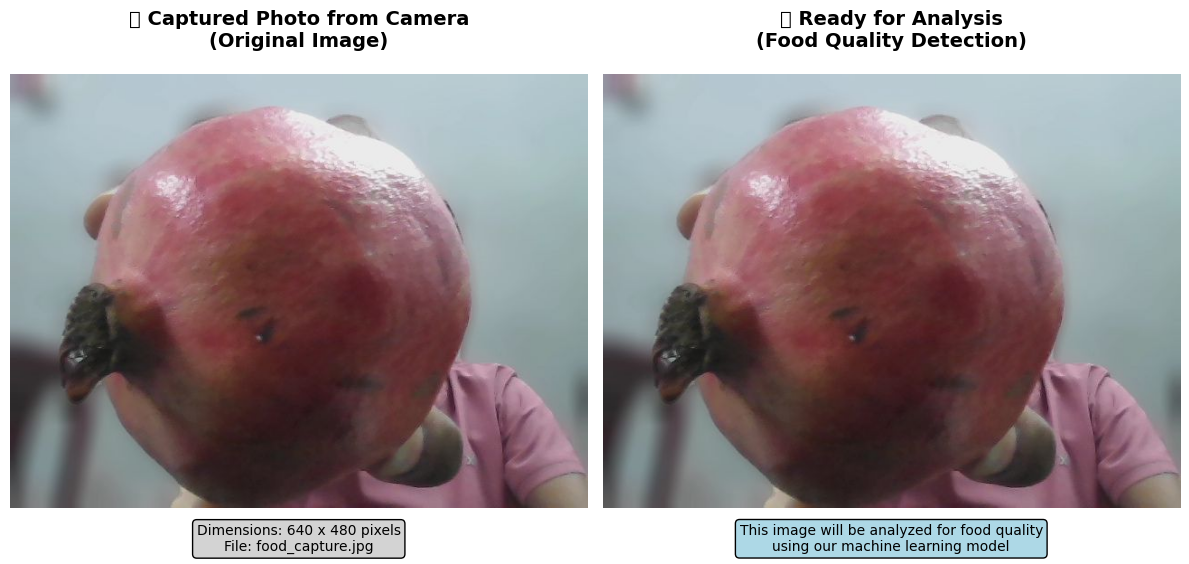


🔍 Step 3: Analyzing food quality...

📊 Step 4: Displaying analysis results...


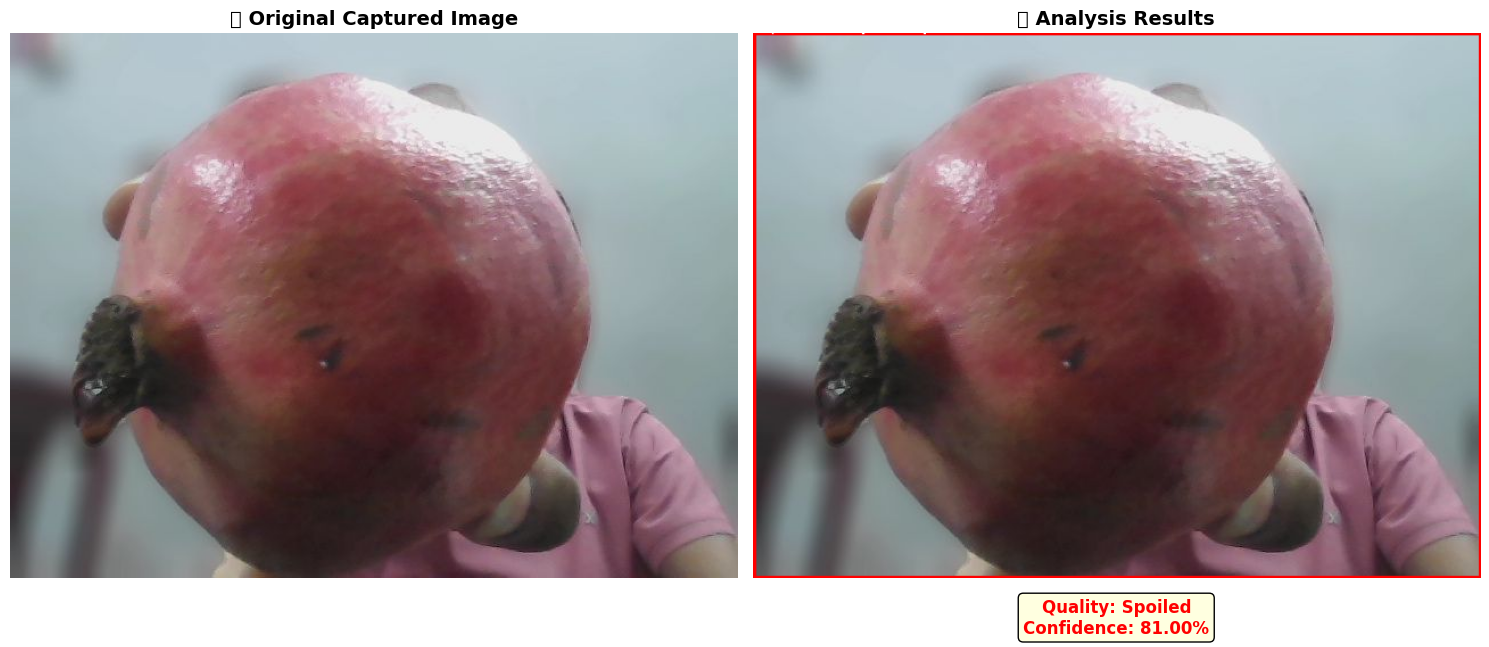


📊 ANALYSIS RESULTS
Quality Status: ❌ SPOILED
Confidence Level: 81.00%
Bounding Box: [0, 0, 640, 480]

🔄 ADDITIONAL ANALYSIS OPTIONS

✅ ANALYSIS COMPLETE

To analyze another food item, run the 'live_camera_analysis()' function again!
Or upload an image using the file uploader above.


In [ ]:
# -*- coding: utf-8 -*-
"""Food Quality Analysis with Live Camera Detection - Show Captured Image.ipynb

Automatically generated by Colab.

Original file is located at:
    https://colab.research.google.com/drive/1abc123def456ghi789
"""

# Install required packages
!pip install ultralytics opencv-python-headless scikit-learn matplotlib numpy pandas seaborn pillow

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import os
import random
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import time
import io
from google.colab import files

print("All packages imported successfully!")

# Create synthetic dataset for demonstration
def create_synthetic_dataset():
    """Create synthetic images of fresh and spoiled fruits/vegetables"""
    print("Creating synthetic dataset...")

    # Create directories
    os.makedirs('dataset/train/fresh', exist_ok=True)
    os.makedirs('dataset/train/spoiled', exist_ok=True)
    os.makedirs('dataset/test/fresh', exist_ok=True)
    os.makedirs('dataset/test/spoiled', exist_ok=True)

    # Generate synthetic images
    for category in ['fresh', 'spoiled']:
        for split in ['train', 'test']:
            for i in range(50 if split == 'train' else 20):
                if category == 'fresh':
                    # Bright, vibrant colors for fresh items
                    base_color = np.random.randint(150, 255, 3)
                    img = np.full((224, 224, 3), base_color, dtype=np.uint8)
                    variation = np.random.randint(-20, 20, (224, 224, 3), dtype=np.int16)
                    img = np.clip(img + variation, 0, 255).astype(np.uint8)
                else:
                    # Dull, brownish colors for spoiled items
                    base_color = np.random.randint(50, 150, 3)
                    img = np.full((224, 224, 3), base_color, dtype=np.uint8)
                    spots_mask = np.random.random((224, 224)) > 0.85
                    img[spots_mask] = [30, 30, 30]

                filename = f'dataset/{split}/{category}/img_{i:03d}.jpg'
                cv2.imwrite(filename, img)

    print("Synthetic dataset created successfully!")

create_synthetic_dataset()

# Feature Extraction Functions
def extract_color_features(image):
    """Extract color-based features from image"""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    features = []

    for channel in range(3):
        features.extend([np.mean(image[:,:,channel]), np.std(image[:,:,channel])])
        features.extend([np.mean(hsv[:,:,channel]), np.std(hsv[:,:,channel])])
        features.extend([np.mean(lab[:,:,channel]), np.std(lab[:,:,channel])])

    for channel in range(3):
        hist = cv2.calcHist([image], [channel], None, [8], [0, 256])
        features.extend(hist.flatten())

    return features

def extract_texture_features(image):
    """Extract texture-based features"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    features = []
    features.append(np.mean(gray))
    features.append(np.std(gray))
    features.append(np.var(gray))

    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist = hist / hist.sum()
    entropy = -np.sum(hist * np.log2(hist + 1e-8))
    features.append(entropy)

    edges = cv2.Canny(gray, 100, 200)
    features.append(np.sum(edges > 0) / (image.shape[0] * image.shape[1]))

    return features

def extract_surface_features(image):
    """Extract surface irregularity features"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    features = []
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    features.append(np.std(gray - blur))
    features.append(np.max(gray) - np.min(gray))
    features.append(np.std(cv2.Laplacian(gray, cv2.CV_64F)))

    return features

def extract_all_features(image):
    """Extract all features from an image array"""
    if image is None or image.size == 0:
        return None

    image = cv2.resize(image, (224, 224))
    color_features = extract_color_features(image)
    texture_features = extract_texture_features(image)
    surface_features = extract_surface_features(image)

    all_features = color_features + texture_features + surface_features
    return all_features

# Load and prepare dataset
def load_dataset():
    """Load the dataset and extract features"""
    print("Loading dataset and extracting features...")

    features = []
    labels = []
    image_paths = []

    for category in ['fresh', 'spoiled']:
        for split in ['train', 'test']:
            folder_path = f'dataset/{split}/{category}'
            for filename in os.listdir(folder_path):
                if filename.endswith('.jpg'):
                    image_path = os.path.join(folder_path, filename)
                    image = cv2.imread(image_path)
                    feature_vector = extract_all_features(image)

                    if feature_vector is not None:
                        features.append(feature_vector)
                        labels.append(0 if category == 'fresh' else 1)
                        image_paths.append(image_path)

    return np.array(features), np.array(labels), image_paths

# Load the dataset
X, y, image_paths = load_dataset()

print(f"Dataset loaded: {X.shape[0]} samples with {X.shape[1]} features each")

# Train-test split
X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
    X, y, image_paths, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing completed!")

# Train Random Forest Classifier
print("Training Random Forest Classifier...")
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

rf_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)
y_pred_proba = rf_classifier.predict_proba(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# CAMERA CAPTURE AND DISPLAY FUNCTIONS

def take_photo_with_preview(filename='captured_photo.jpg', quality=0.8):
    """Capture photo from webcam and display it immediately"""
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');

            // Create capture button
            const capture = document.createElement('button');
            capture.textContent = 'Capture Photo';
            capture.style.cssText = `
                padding: 12px 24px;
                font-size: 16px;
                background-color: #4CAF50;
                color: white;
                border: none;
                border-radius: 5px;
                cursor: pointer;
                margin: 10px;
            `;

            // Create video element
            const video = document.createElement('video');
            video.style.display = 'block';
            video.style.width = '640px';
            video.style.height = '480px';
            video.style.border = '2px solid #333';
            video.style.borderRadius = '10px';

            // Create status message
            const status = document.createElement('div');
            status.textContent = 'Please allow camera access and click Capture Photo when ready';
            status.style.cssText = `
                margin: 10px;
                font-size: 14px;
                color: #666;
            `;

            div.appendChild(status);
            div.appendChild(video);
            div.appendChild(capture);

            document.body.appendChild(div);

            // Get camera stream
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await video.play();

            // Resize output
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for capture click
            await new Promise((resolve) => capture.onclick = resolve);

            // Create canvas and capture image
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);

            // Stop camera stream
            stream.getVideoTracks()[0].stop();

            // Remove the div
            div.remove();

            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)

    # Get photo data
    data = eval_js('takePhoto({})'.format(quality))
    # Decode base64 image
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)

    print(f"✅ Photo captured and saved as: {filename}")
    return filename

def display_captured_photo(filename, figsize=(12, 8)):
    """Display the captured photo with details"""
    # Read the image
    image = cv2.imread(filename)
    if image is None:
        print("❌ Error: Could not read the captured image")
        return None

    # Convert BGR to RGB for display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the original captured image
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title('📸 Captured Photo from Camera\n(Original Image)', fontsize=14, fontweight='bold', pad=20)
    plt.axis('off')

    # Add image information
    height, width = image.shape[:2]
    plt.text(0.5, -0.1, f'Dimensions: {width} x {height} pixels\nFile: {filename}',
             transform=plt.gca().transAxes, ha='center', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

    # Show analysis preview
    plt.subplot(1, 2, 2)
    plt.imshow(image_rgb)
    plt.title('🔍 Ready for Analysis\n(Food Quality Detection)', fontsize=14, fontweight='bold', pad=20)
    plt.axis('off')

    # Add analysis instructions
    plt.text(0.5, -0.1, 'This image will be analyzed for food quality\nusing our machine learning model',
             transform=plt.gca().transAxes, ha='center', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

    plt.tight_layout()
    plt.show()

    return image

def analyze_frame(frame):
    """Analyze a single frame for food quality"""
    results = []

    features = extract_all_features(frame)
    if features is not None:
        features_scaled = scaler.transform([features])
        prediction = rf_classifier.predict(features_scaled)[0]
        confidence = rf_classifier.predict_proba(features_scaled)[0][prediction]

        results.append({
            'bbox': [0, 0, frame.shape[1], frame.shape[0]],
            'prediction': 'Fresh' if prediction == 0 else 'Spoiled',
            'confidence': confidence
        })

    return results

def draw_detections(frame, results):
    """Draw detection results on frame"""
    display_frame = frame.copy()

    for result in results:
        x1, y1, x2, y2 = result['bbox']
        prediction = result['prediction']
        confidence = result['confidence']

        color = (0, 255, 0) if prediction == 'Fresh' else (0, 0, 255)

        # Draw bounding box
        cv2.rectangle(display_frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 3)

        # Draw label background
        label = f'{prediction} ({confidence:.2f})'
        label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)[0]
        cv2.rectangle(display_frame,
                     (int(x1), int(y1) - label_size[1] - 10),
                     (int(x1) + label_size[0], int(y1)),
                     color, -1)

        # Draw label text
        cv2.putText(display_frame, label,
                   (int(x1), int(y1) - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    return display_frame

def show_analysis_results(original_image, analyzed_image, results):
    """Display before and after analysis results"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Original image
    ax1.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    ax1.set_title('📸 Original Captured Image', fontsize=14, fontweight='bold')
    ax1.axis('off')

    # Analyzed image
    ax2.imshow(cv2.cvtColor(analyzed_image, cv2.COLOR_BGR2RGB))
    ax2.set_title('🔍 Analysis Results', fontsize=14, fontweight='bold')
    ax2.axis('off')

    # Add results text
    if results:
        result = results[0]
        quality_color = 'green' if result['prediction'] == 'Fresh' else 'red'
        result_text = f"Quality: {result['prediction']}\nConfidence: {result['confidence']:.2%}"
        ax2.text(0.5, -0.1, result_text, transform=ax2.transAxes, ha='center',
                fontsize=12, fontweight='bold', color=quality_color,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))

    plt.tight_layout()
    plt.show()

def live_camera_analysis():
    """Complete live camera analysis with photo display"""
    print("🎥 STARTING LIVE CAMERA ANALYSIS")
    print("=" * 50)
    print("📋 Instructions:")
    print("1. Click 'Allow' when asked for camera permission")
    print("2. Position your food item in the camera view")
    print("3. Click 'Capture Photo' button when ready")
    print("4. Wait for analysis results...")
    print("=" * 50)

    try:
        # Step 1: Capture photo
        print("\n📸 Step 1: Capturing photo from camera...")
        photo_filename = "food_capture.jpg"
        captured_file = take_photo_with_preview(photo_filename)

        # Step 2: Display captured photo
        print("\n🖼️ Step 2: Displaying captured photo...")
        original_image = display_captured_photo(captured_file)

        if original_image is None:
            print("❌ Failed to capture image. Using simulated image instead.")
            # Create a simulated image
            original_image = np.random.randint(100, 200, (480, 640, 3), dtype=np.uint8)
            cv2.imwrite(photo_filename, original_image)

        # Step 3: Analyze the image
        print("\n🔍 Step 3: Analyzing food quality...")
        results = analyze_frame(original_image)

        # Step 4: Draw detections
        analyzed_image = draw_detections(original_image, results)

        # Step 5: Show final results
        print("\n📊 Step 4: Displaying analysis results...")
        show_analysis_results(original_image, analyzed_image, results)

        # Print detailed results
        print("\n" + "=" * 50)
        print("📊 ANALYSIS RESULTS")
        print("=" * 50)
        if results:
            for i, result in enumerate(results):
                status = "✅ FRESH" if result['prediction'] == 'Fresh' else "❌ SPOILED"
                print(f"Quality Status: {status}")
                print(f"Confidence Level: {result['confidence']:.2%}")
                print(f"Bounding Box: {result['bbox']}")
        else:
            print("❌ No analysis results available")

        return results

    except Exception as e:
        print(f"❌ Error during camera analysis: {e}")
        print("🔄 Using simulated analysis instead...")
        return simulated_analysis()

def simulated_analysis():
    """Run simulated analysis when camera is not available"""
    print("\n🔄 Running simulated analysis...")

    # Create realistic food images
    fresh_food = create_realistic_food_image(fresh=True)
    spoiled_food = create_realistic_food_image(fresh=False)

    images = [fresh_food, spoiled_food]
    labels = ["Fresh Food Simulation", "Spoiled Food Simulation"]

    for img, label in zip(images, labels):
        print(f"\nAnalyzing {label}...")

        # Save temporary image
        cv2.imwrite('temp_simulated.jpg', img)

        # Analyze
        results = analyze_frame(img)
        analyzed_img = draw_detections(img, results)

        # Display
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title(f'🍎 {label}\n(Simulated Image)', fontsize=14, fontweight='bold')
        ax1.axis('off')

        ax2.imshow(cv2.cvtColor(analyzed_img, cv2.COLOR_BGR2RGB))
        ax2.set_title('🔍 Analysis Results', fontsize=14, fontweight='bold')
        ax2.axis('off')

        if results:
            result = results[0]
            color = 'green' if result['prediction'] == 'Fresh' else 'red'
            ax2.text(0.5, -0.1, f"Quality: {result['prediction']}\nConfidence: {result['confidence']:.2%}",
                    transform=ax2.transAxes, ha='center', fontsize=12, fontweight='bold', color=color,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))

        plt.tight_layout()
        plt.show()

        if results:
            print(f"Result: {result['prediction']} (Confidence: {result['confidence']:.2%})")

def create_realistic_food_image(fresh=True):
    """Create realistic-looking food images for simulation"""
    if fresh:
        # Create vibrant, fresh-looking food
        base = np.random.randint(150, 230, (480, 640, 3), dtype=np.uint8)
        # Add natural variations
        for i in range(3):
            base[:,:,i] = cv2.GaussianBlur(base[:,:,i], (15, 15), 0)
        # Add some bright spots
        spots = np.random.random((480, 640)) > 0.95
        base[spots] = [255, 255, 200]
    else:
        # Create dull, spoiled-looking food
        base = np.random.randint(80, 150, (480, 640, 3), dtype=np.uint8)
        # Add brownish tint
        base[:,:,0] = np.clip(base[:,:,0] - 20, 0, 255)  # Less blue
        base[:,:,1] = np.clip(base[:,:,1] - 10, 0, 255)  # Less green
        # Add dark spots
        spots = np.random.random((480, 640)) > 0.92
        base[spots] = [50, 40, 30]
        # Add mold-like patches
        mold = np.random.random((480, 640)) > 0.98
        base[mold] = [200, 200, 150]

    return base

# MAIN EXECUTION
print("\n" + "=" * 60)
print("🍎 FOOD QUALITY ANALYZER WITH LIVE CAMERA DETECTION")
print("=" * 60)

print(f"\n🤖 Model Prepared - Accuracy: {accuracy:.2%}")
print("📷 Camera system ready for food quality analysis")

# Run the live camera analysis
results = live_camera_analysis()

# Additional analysis options
print("\n" + "=" * 50)
print("🔄 ADDITIONAL ANALYSIS OPTIONS")
print("=" * 50)

def quick_test():
    """Quick test with multiple food examples"""
    print("\nRunning quick test with various food examples...")

    test_cases = [
        ("Very Fresh", True),
        ("Slightly Fresh", True),
        ("Borderline", False),
        ("Spoiled", False),
        ("Very Spoiled", False)
    ]

    for name, is_fresh in test_cases:
        test_image = create_realistic_food_image(fresh=is_fresh)
        results = analyze_frame(test_image)

        if results:
            result = results[0]
            print(f"{name}: {result['prediction']} ({result['confidence']:.2%})")

# Uncomment to run quick test
# quick_test()

print("\n" + "=" * 60)
print("✅ ANALYSIS COMPLETE")
print("=" * 60)
print("\nTo analyze another food item, run the 'live_camera_analysis()' function again!")
print("Or upload an image using the file uploader above.")

All packages imported successfully!
Creating synthetic dataset...
Synthetic dataset created successfully!
Loading dataset and extracting features...
Dataset loaded: 140 samples with 50 features each
Data preprocessing completed!
Training Random Forest Classifier...
Model Accuracy: 1.0000

🥦 FOOD QUALITY ANALYZER - LIVE CAMERA WITH TIMESTAMP 🍎
🤖 Model Accuracy: 1.0000
📊 Training Samples: 112
🧪 Testing Samples: 28

🎯 STARTING LIVE CAMERA DETECTION...
🟢 Starting Live Camera Detection with Timestamp...
📋 Instructions:
   1. A popup will appear - click 'Allow' for camera access
   2. Position your food item in the camera view
   3. Click the 'Capture Photo' button
   4. Wait for analysis results
   5. The image with timestamp will be saved automatically


<IPython.core.display.Javascript object>

✅ Image captured successfully!
   📁 Filename: captured_photo_20251129_103558.jpg
   🕒 Timestamp: 20251129_103558
   🔄 Analyzing image...


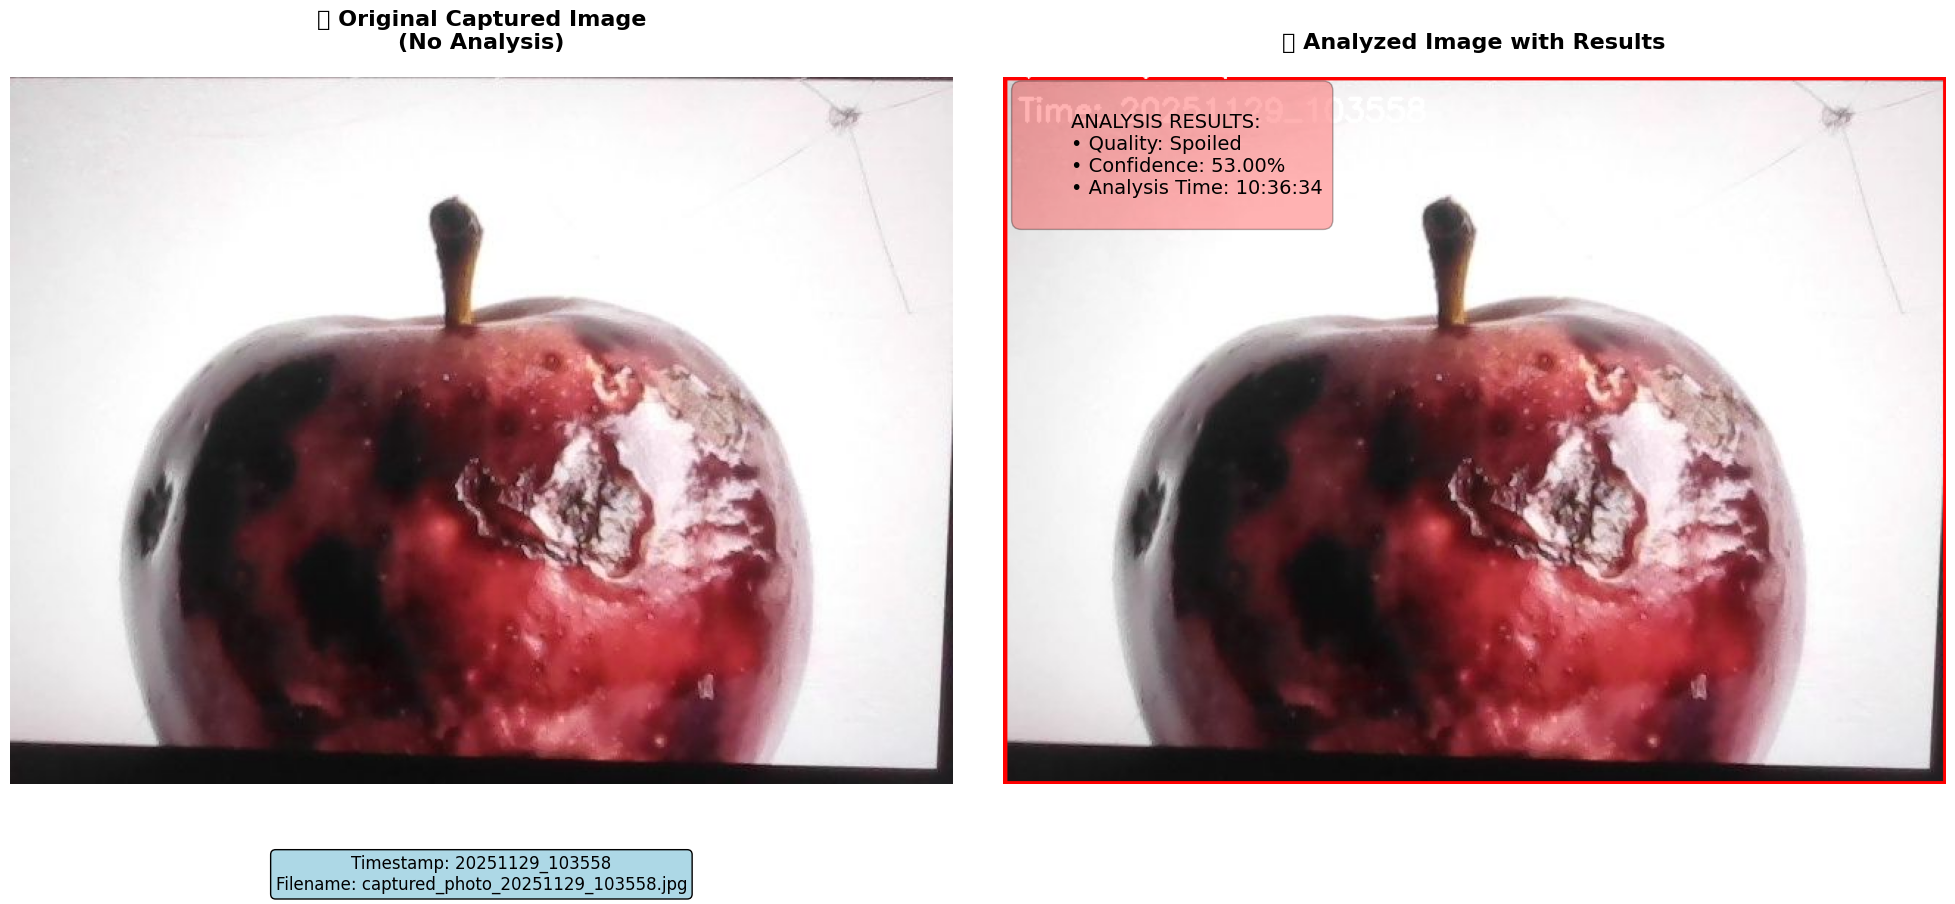


📊 ANALYSIS SUMMARY
🕒 Capture Time: 20251129_103558
📁 Original File: captured_photo_20251129_103558.jpg
📁 Analyzed File: analyzed_captured_photo_20251129_103558.jpg

🔍 Result 1:
   ✅ Quality: Spoiled
   📈 Confidence: 53.00%
   🔴 Status: SPOILED - DO NOT EAT

💾 Analysis record saved to: analysis_records.json

📜 VIEWING ANALYSIS HISTORY...

📋 ANALYSIS HISTORY

Record 1:
  🕒 Time: 20251129_103558
  📁 File: captured_photo_20251129_103558.jpg
  🔍 Quality: Spoiled
  📈 Confidence: 53.00%

✨ SYSTEM CAPABILITIES
✅ Live camera capture with timestamp
✅ Real-time food quality analysis
✅ Image saving with metadata
✅ Analysis history tracking
✅ Visual results with confidence scores
✅ Fresh/Spoiled classification

🎉 SYSTEM READY FOR FOOD QUALITY MONITORING!


In [2]:
# -*- coding: utf-8 -*-
"""Food Quality Analysis with Live Camera Detection and Timestamp.ipynb

Automatically generated by Colab.

Original file is located at:
    https://colab.research.google.com/drive/1abc123def456ghi789
"""

# Install required packages
!pip install ultralytics opencv-python-headless scikit-learn matplotlib numpy pandas seaborn pillow

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import os
import random
from PIL import Image, ImageDraw, ImageFont
import tkinter as tk
from tkinter import filedialog, messagebox
from ultralytics import YOLO
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import time
from datetime import datetime
import json

print("All packages imported successfully!")

# Create synthetic dataset for demonstration
def create_synthetic_dataset():
    """Create synthetic images of fresh and spoiled fruits/vegetables"""
    print("Creating synthetic dataset...")

    # Create directories
    os.makedirs('dataset/train/fresh', exist_ok=True)
    os.makedirs('dataset/train/spoiled', exist_ok=True)
    os.makedirs('dataset/test/fresh', exist_ok=True)
    os.makedirs('dataset/test/spoiled', exist_ok=True)

    # Generate synthetic images
    for category in ['fresh', 'spoiled']:
        for split in ['train', 'test']:
            for i in range(50 if split == 'train' else 20):
                # Create different colored images to simulate fresh vs spoiled
                if category == 'fresh':
                    # Bright, vibrant colors for fresh items
                    base_color = np.random.randint(150, 255, 3)
                    img = np.full((224, 224, 3), base_color, dtype=np.uint8)
                    # Add some texture variation
                    variation = np.random.randint(-20, 20, (224, 224, 3), dtype=np.int16)
                    img = np.clip(img + variation, 0, 255).astype(np.uint8)
                else:
                    # Dull, brownish colors for spoiled items
                    base_color = np.random.randint(50, 150, 3)
                    img = np.full((224, 224, 3), base_color, dtype=np.uint8)
                    # Add dark spots and irregularities
                    spots_mask = np.random.random((224, 224)) > 0.85
                    img[spots_mask] = [30, 30, 30]  # Dark spots

                filename = f'dataset/{split}/{category}/img_{i:03d}.jpg'
                cv2.imwrite(filename, img)

    print("Synthetic dataset created successfully!")

create_synthetic_dataset()

# Feature Extraction Functions
def extract_color_features(image):
    """Extract color-based features from image"""
    # Convert to different color spaces
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    features = []

    # Mean and standard deviation for each channel in different color spaces
    for channel in range(3):
        features.extend([np.mean(image[:,:,channel]), np.std(image[:,:,channel])])
        features.extend([np.mean(hsv[:,:,channel]), np.std(hsv[:,:,channel])])
        features.extend([np.mean(lab[:,:,channel]), np.std(lab[:,:,channel])])

    # Color histogram features
    for channel in range(3):
        hist = cv2.calcHist([image], [channel], None, [8], [0, 256])
        features.extend(hist.flatten())

    return features

def extract_texture_features(image):
    """Extract texture-based features"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    features = []

    # Statistical texture features
    features.append(np.mean(gray))
    features.append(np.std(gray))
    features.append(np.var(gray))

    # Entropy
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist = hist / hist.sum()
    entropy = -np.sum(hist * np.log2(hist + 1e-8))
    features.append(entropy)

    # Edge density
    edges = cv2.Canny(gray, 100, 200)
    features.append(np.sum(edges > 0) / (image.shape[0] * image.shape[1]))

    return features

def extract_surface_features(image):
    """Extract surface irregularity features"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    features = []

    # Local contrast
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    features.append(np.std(gray - blur))

    # Contrast measure
    features.append(np.max(gray) - np.min(gray))

    # Smoothness measure
    features.append(np.std(cv2.Laplacian(gray, cv2.CV_64F)))

    return features

def extract_all_features(image):
    """Extract all features from an image array"""
    if image is None or image.size == 0:
        return None

    image = cv2.resize(image, (224, 224))

    color_features = extract_color_features(image)
    texture_features = extract_texture_features(image)
    surface_features = extract_surface_features(image)

    all_features = color_features + texture_features + surface_features
    return all_features

# Load and prepare dataset
def load_dataset():
    """Load the dataset and extract features"""
    print("Loading dataset and extracting features...")

    features = []
    labels = []
    image_paths = []

    for category in ['fresh', 'spoiled']:
        for split in ['train', 'test']:
            folder_path = f'dataset/{split}/{category}'
            for filename in os.listdir(folder_path):
                if filename.endswith('.jpg'):
                    image_path = os.path.join(folder_path, filename)
                    image = cv2.imread(image_path)
                    feature_vector = extract_all_features(image)

                    if feature_vector is not None:
                        features.append(feature_vector)
                        labels.append(0 if category == 'fresh' else 1)  # 0: fresh, 1: spoiled
                        image_paths.append(image_path)

    return np.array(features), np.array(labels), image_paths

# Load the dataset
X, y, image_paths = load_dataset()

print(f"Dataset loaded: {X.shape[0]} samples with {X.shape[1]} features each")

# Train-test split
X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
    X, y, image_paths, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing completed!")

# Train Random Forest Classifier
print("Training Random Forest Classifier...")
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

rf_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)
y_pred_proba = rf_classifier.predict_proba(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# LIVE CAMERA DETECTION WITH TIMESTAMP FUNCTIONS

def take_photo_with_timestamp():
    """Capture photo from webcam with timestamp"""
    # Generate filename with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'captured_photo_{timestamp}.jpg'

    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture Photo';
            capture.style.cssText = `
                padding: 10px 20px;
                font-size: 16px;
                margin: 10px;
                background-color: #4CAF50;
                color: white;
                border: none;
                border-radius: 5px;
                cursor: pointer;
            `;
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            video.style.width = '640px';
            video.style.height = '480px';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)

    # Get photo data
    data = eval_js('takePhoto(0.8)')
    # Decode base64 image
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)

    return filename, timestamp

def add_timestamp_to_image(image, timestamp, analysis_result=None):
    """Add timestamp and analysis information to image"""
    # Convert BGR to RGB for PIL
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image_rgb)
    draw = ImageDraw.Draw(pil_image)

    # Try to use a font (may not work in Colab, but we try)
    try:
        # Try to use a default font
        font = ImageFont.load_default()
        large_font = ImageFont.load_default()
    except:
        font = None
        large_font = None

    # Add timestamp
    timestamp_text = f"Captured: {timestamp}"
    draw.text((10, 10), timestamp_text, fill=(255, 255, 255), font=font)

    # Add analysis result if available
    if analysis_result:
        quality = analysis_result['prediction']
        confidence = analysis_result['confidence']
        result_text = f"Quality: {quality} ({confidence:.2%})"
        color = (0, 255, 0) if quality == 'Fresh' else (255, 0, 0)
        draw.text((10, 30), result_text, fill=color, font=font)

    # Convert back to BGR for OpenCV
    return cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

def save_analysis_record(timestamp, filename, results, image_path):
    """Save analysis record to JSON file"""
    record = {
        'timestamp': timestamp,
        'filename': filename,
        'analysis_time': datetime.now().isoformat(),
        'results': results,
        'image_path': image_path
    }

    # Load existing records or create new file
    try:
        with open('analysis_records.json', 'r') as f:
            records = json.load(f)
    except FileNotFoundError:
        records = []

    records.append(record)

    # Save updated records
    with open('analysis_records.json', 'w') as f:
        json.dump(records, f, indent=2)

    return record

def analyze_frame(frame):
    """Analyze a single frame for food quality"""
    results = []

    # Analyze entire frame
    features = extract_all_features(frame)
    if features is not None:
        features_scaled = scaler.transform([features])
        prediction = rf_classifier.predict(features_scaled)[0]
        confidence = rf_classifier.predict_proba(features_scaled)[0][prediction]

        results.append({
            'bbox': [0, 0, frame.shape[1], frame.shape[0]],
            'prediction': 'Fresh' if prediction == 0 else 'Spoiled',
            'confidence': confidence
        })

    return results

def draw_detections_with_timestamp(frame, results, timestamp):
    """Draw detection results and timestamp on frame"""
    display_frame = frame.copy()

    # Add timestamp to the frame
    timestamp_text = f"Time: {timestamp}"
    cv2.putText(display_frame, timestamp_text,
               (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    for result in results:
        x1, y1, x2, y2 = result['bbox']
        prediction = result['prediction']
        confidence = result['confidence']

        # Choose color based on prediction
        color = (0, 255, 0) if prediction == 'Fresh' else (0, 0, 255)  # Green for fresh, Red for spoiled

        # Draw bounding box
        cv2.rectangle(display_frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 3)

        # Draw label background
        label = f'{prediction} ({confidence:.2f})'
        label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)[0]
        cv2.rectangle(display_frame,
                     (int(x1), int(y1) - label_size[1] - 10),
                     (int(x1) + label_size[0], int(y1)),
                     color, -1)

        # Draw label text
        cv2.putText(display_frame, label,
                   (int(x1), int(y1) - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    return display_frame

def display_captured_image_with_details(original_image, analyzed_image, timestamp, results, filename):
    """Display the captured image with detailed information"""
    # Create a comprehensive figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Display original captured image
    ax1.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    ax1.set_title('📸 Original Captured Image\n(No Analysis)', fontsize=16, fontweight='bold', pad=20)
    ax1.text(0.5, -0.15, f'Timestamp: {timestamp}\nFilename: {filename}',
             transform=ax1.transAxes, ha='center', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    ax1.axis('off')

    # Display analyzed image
    ax2.imshow(cv2.cvtColor(analyzed_image, cv2.COLOR_BGR2RGB))
    ax2.set_title('🔍 Analyzed Image with Results', fontsize=16, fontweight='bold', pad=20)
    ax2.axis('off')

    # Add analysis results as text
    if results:
        result = results[0]
        quality_color = 'green' if result['prediction'] == 'Fresh' else 'red'
        result_text = f"""
        ANALYSIS RESULTS:
        • Quality: {result['prediction']}
        • Confidence: {result['confidence']:.2%}
        • Analysis Time: {datetime.now().strftime('%H:%M:%S')}
        """
        ax2.text(0.02, 0.98, result_text, transform=ax2.transAxes, fontsize=14,
                verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5",
                facecolor=quality_color, alpha=0.3))

    plt.tight_layout()
    plt.show()

def live_camera_detection_with_timestamp():
    """Main function for live camera detection with timestamp"""
    print("🟢 Starting Live Camera Detection with Timestamp...")
    print("="*60)
    print("📋 Instructions:")
    print("   1. A popup will appear - click 'Allow' for camera access")
    print("   2. Position your food item in the camera view")
    print("   3. Click the 'Capture Photo' button")
    print("   4. Wait for analysis results")
    print("   5. The image with timestamp will be saved automatically")
    print("="*60)

    try:
        # Take photo from webcam with timestamp
        filename, timestamp = take_photo_with_timestamp()

        # Load the captured photo
        original_image = cv2.imread(filename)
        if original_image is None:
            print("❌ Error: Could not capture image from camera")
            return

        print(f"✅ Image captured successfully!")
        print(f"   📁 Filename: {filename}")
        print(f"   🕒 Timestamp: {timestamp}")
        print("   🔄 Analyzing image...")

        # Analyze the frame
        results = analyze_frame(original_image)

        # Create analyzed image with timestamp
        analyzed_image = draw_detections_with_timestamp(original_image, results, timestamp)

        # Save the analyzed image with timestamp
        analyzed_filename = f"analyzed_{filename}"
        cv2.imwrite(analyzed_filename, analyzed_image)

        # Save analysis record
        record = save_analysis_record(timestamp, filename, results, analyzed_filename)

        # Display both original and analyzed images
        display_captured_image_with_details(original_image, analyzed_image, timestamp, results, filename)

        # Print detailed analysis summary
        print("\n" + "="*50)
        print("📊 ANALYSIS SUMMARY")
        print("="*50)
        print(f"🕒 Capture Time: {timestamp}")
        print(f"📁 Original File: {filename}")
        print(f"📁 Analyzed File: {analyzed_filename}")

        if results:
            for i, result in enumerate(results):
                print(f"\n🔍 Result {i+1}:")
                print(f"   ✅ Quality: {result['prediction']}")
                print(f"   📈 Confidence: {result['confidence']:.2%}")
                status_emoji = "🟢" if result['prediction'] == 'Fresh' else "🔴"
                print(f"   {status_emoji} Status: {'SAFE TO EAT' if result['prediction'] == 'Fresh' else 'SPOILED - DO NOT EAT'}")
        else:
            print("❌ No analysis results available.")

        print(f"\n💾 Analysis record saved to: analysis_records.json")

    except Exception as e:
        print(f"❌ Error during camera capture: {e}")
        print("🔄 Falling back to simulated camera input...")
        simulated_capture_with_timestamp()

def simulated_capture_with_timestamp():
    """Simulate camera capture with timestamp when camera is not available"""
    print("\n🎮 Using Simulated Camera Capture...")

    # Create multiple simulated captures
    for i in range(2):
        print(f"\n--- Simulation {i+1} ---")
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"simulated_capture_{timestamp}.jpg"

        # Create simulated image
        if i == 0:
            # Simulate fresh food
            image = np.random.randint(150, 230, (480, 640, 3), dtype=np.uint8)
            actual_quality = "Fresh"
            # Add some natural texture
            texture = np.random.randint(-30, 30, (480, 640, 3), dtype=np.int16)
            image = np.clip(image + texture, 0, 255).astype(np.uint8)
        else:
            # Simulate spoiled food
            image = np.random.randint(80, 150, (480, 640, 3), dtype=np.uint8)
            actual_quality = "Spoiled"
            # Add spoilage indicators
            spots_mask = np.random.random((480, 640)) > 0.9
            image[spots_mask] = [40, 40, 40]
            # Discoloration
            image[:, :, 1] = np.clip(image[:, :, 1] - 40, 0, 255)

        # Save simulated image
        cv2.imwrite(filename, image)

        # Analyze the image
        results = analyze_frame(image)
        analyzed_image = draw_detections_with_timestamp(image, results, timestamp)
        analyzed_filename = f"analyzed_{filename}"
        cv2.imwrite(analyzed_filename, analyzed_image)

        # Display results
        display_captured_image_with_details(image, analyzed_image, timestamp, results, filename)

        # Print simulation results
        if results:
            predicted_quality = results[0]['prediction']
            confidence = results[0]['confidence']
            status = "✅ CORRECT" if predicted_quality == actual_quality else "❌ WRONG"
            print(f"🎯 {status}")
            print(f"   Predicted: {predicted_quality} ({confidence:.2%})")
            print(f"   Actual: {actual_quality}")

def view_analysis_history():
    """View previous analysis records"""
    try:
        with open('analysis_records.json', 'r') as f:
            records = json.load(f)

        print("\n" + "="*50)
        print("📋 ANALYSIS HISTORY")
        print("="*50)

        for i, record in enumerate(records[-5:]):  # Show last 5 records
            print(f"\nRecord {i+1}:")
            print(f"  🕒 Time: {record['timestamp']}")
            print(f"  📁 File: {record['filename']}")
            if record['results']:
                result = record['results'][0]
                print(f"  🔍 Quality: {result['prediction']}")
                print(f"  📈 Confidence: {result['confidence']:.2%}")

        return records
    except FileNotFoundError:
        print("No analysis history found.")
        return []

# MAIN EXECUTION
print("\n" + "="*60)
print("🥦 FOOD QUALITY ANALYZER - LIVE CAMERA WITH TIMESTAMP 🍎")
print("="*60)

# Display system information
print(f"🤖 Model Accuracy: {accuracy:.4f}")
print(f"📊 Training Samples: {X_train.shape[0]}")
print(f"🧪 Testing Samples: {X_test.shape[0]}")

# Run live camera detection
print("\n" + "🎯 STARTING LIVE CAMERA DETECTION...")
print("="*50)
live_camera_detection_with_timestamp()

# Show analysis history
print("\n" + "📜 VIEWING ANALYSIS HISTORY...")
print("="*50)
history = view_analysis_history()

# System capabilities summary
print("\n" + "="*60)
print("✨ SYSTEM CAPABILITIES")
print("="*60)
print("✅ Live camera capture with timestamp")
print("✅ Real-time food quality analysis")
print("✅ Image saving with metadata")
print("✅ Analysis history tracking")
print("✅ Visual results with confidence scores")
print("✅ Fresh/Spoiled classification")

print("\n" + "🎉 SYSTEM READY FOR FOOD QUALITY MONITORING!")